# Imports

In [ ]:
import pandas as pd
!pip install contractions
import operator
import contractions     
import re           
import nltk                   
nltk.download('stopwords')             # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords            # Import stopwords.
from nltk.tokenize import word_tokenize # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
from nltk.stem import PorterStemmer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.0 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import numpy as np
import pandas as pd
import tensorflow
from keras.preprocessing.text import Tokenizer

from keras.utils import pad_sequences
from keras.utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten, AveragePooling1D
from keras.models import Model

from IPython.terminal.embed import embed
from keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import tensorflow as tf
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential



In [ ]:
# Incase the code will be tested on google collab you can use this folder on google collab instead of uploading the data
# https://drive.google.com/drive/folders/1DSMCjFfiLa90UrIETTqwVegvoirfd6b7?usp=sharing --> for the Data
# https://drive.google.com/file/d/1sUNr4tuKAe7Qgy_DHZNltrF3s3dFBHMY/view?usp=sharing --> for glove
# In order to be able to access files click on the folder and select "Add shortcut to Drive"
 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Original Data

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/DataWithLemma/file.csv') --> using drive folder
data = pd.read_csv("Data/file.csv") 

In [ ]:
data.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [ ]:
data = data.drop('Unnamed: 0', axis=1) # drop first column
data

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
...,...,...
219289,Other Software Projects Are Now Trying to Repl...,bad
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good
219291,chatgpt is being disassembled until it can onl...,bad
219292,2023 predictions by #chatGPT. Nothing really s...,bad


# Preprocessing

In [ ]:
def removePunctuation(words):
  newWords = []
  for word in words:
    # Not word or space, then remove
      newWord = re.sub(r'[^\w\s]', '', word)
      if newWord != '':
          newWords.append(newWord)
  return newWords

def removeStopwords(words):
  stopwordsList = stopwords.words('english') 
  newWords = []
  for word in words:
      if word not in stopwordsList:
          newWords.append(word)
  return newWords

def lemmatize(words):
  lemmatizer = WordNetLemmatizer()
  newWords = []
  for word in words:
    newWords.append(lemmatizer.lemmatize(word, pos='v')) 
  return newWords

def stemming(words):
  stemmer = PorterStemmer()
  stemmedWords = []
  for word in words:
    stemmedWords.append(stemmer.stem(word)) 
  return stemmedWords

def removeLinks(data):
  newLine = re.sub('http://\S+|https://\S+', '', data)
  return newLine

def removeEmails(data):
  newLine = re.sub('(\w)+|((\w)+\.(\w)+)@[a-zA-Z]+\.[a-zA-Z]++', '', data)
  return newLine

def preprocessing(data):
  # you're' -> you are
  data = contractions.fix(data)
  dataLowercase = data.lower() 

  dataNolinks= removeLinks(dataLowercase) #-->

  dataTokens = nltk.word_tokenize(dataNolinks)

  dataTokens = removePunctuation(dataTokens)
  dataTokens = removeStopwords(dataTokens)
  modifiedDataTokens = lemmatize(dataTokens)
  #modifiedDataTokens = stemming(modifiedDataTokens) 

  return modifiedDataTokens


In [ ]:
def preprocessingData(data):
  for index, row in data.iterrows():
    data.at[index,'tweets'] = ' '.join(preprocessing(row['tweets']))
  return data

In [ ]:
newData = preprocessingData(data)
newData.head()

,tweets,labels
0,chatgpt optimize language model dialogue openai,neutral
1,try talk chatgpt new ai system optimize dialog...,good
2,chatgpt optimize language model dialogue ai ma...,neutral
3,thrill share chatgpt new model optimize dialog...,good
4,2 minutes ago openai release new chatgpt nnand...,bad


# Word Index and Embedding

In [ ]:
def createDictionary(texts):
  tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
  tokenizer.fit_on_texts(texts)
  sequences = tokenizer.texts_to_sequences(texts)
  wordIndex = tokenizer.word_index # the dictionary 
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

  return data, wordIndex


In [ ]:
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 300
embedData , wordIndex = createDictionary(newData['tweets'])
print(embedData)
print()
print(wordIndex)

In [ ]:
print(embedData[0])

# Shuffle, Split, and Save Data

In [ ]:

def shuffleAndSplitData(embedData, data, newData):
  TEST_SPLIT = 0.2
  indices = np.arange(data.shape[0])
  np.random.shuffle(indices)

  data_shuffled = data.reindex(indices)
  # --> 
  newData_shuffled = newData.reindex(indices)


  labels_shuffled = data_shuffled['labels']
  embed_shuffled = embedData[indices]

  nb_test_samples = int(TEST_SPLIT * embed_shuffled.shape[0])

  # Actual Data (will be used)
  x_train = embed_shuffled[:-nb_test_samples]
  y_train = labels_shuffled[:-nb_test_samples]

  x_test = embed_shuffled[-nb_test_samples:]
  y_test = labels_shuffled[-nb_test_samples:]
  print('Shape of training data: ',x_train.shape)
  print('Shape of testing data: ',x_test.shape)

  # Original Data Spliting
  dataTrain = data_shuffled[:-nb_test_samples]
  dataTest = data_shuffled[-nb_test_samples:]

  dataTrain.to_csv('dataTrain.csv')
  dataTest.to_csv('dataTest.csv')

  # Preprocessed Data (before embedding)
  newDataTrain = newData_shuffled[:-nb_test_samples]
  newDataTest = newData_shuffled[-nb_test_samples:]

  dataTrain.to_csv('PreprocessedDataTrain.csv')
  dataTest.to_csv('PreprocessedDataTest.csv')

  #Preprocessed Data (after embedding)
  dfTrain = pd.DataFrame(x_train)
  dfTest = pd.DataFrame(x_test)

  dfTrain.to_csv('dataTrainEmbed.csv')
  dfTest.to_csv('dataTestEmbed.csv')

  return x_train,y_train,x_test,y_test


In [ ]:
x_train,y_train,x_test,y_test = shuffleAndSplitData(embedData, data, newData)

Shape of training data:  (175436, 300)
Shape of testing data:  (43858, 300)


# Load Shuffled Data

In [ ]:
# Using Drive Folder
# preprocessedDataTest = pd.read_csv('/content/drive/MyDrive/DataWithLemma/PreprocessedDataTest.csv')
# preprocessedDataTrain = pd.read_csv('/content/drive/MyDrive/DataWithLemma/PreprocessedDataTrain.csv')

# dataTrainEmbed = pd.read_csv('/content/drive/MyDrive/DataWithLemma/dataTrainEmbed.csv')
# dataTestEmbed = pd.read_csv('/content/drive/MyDrive/DataWithLemma/dataTestEmbed.csv')

In [ ]:
# Using Data uploaded with the file

preprocessedDataTest = pd.read_csv('Data/PreprocessedDataTest.csv')
preprocessedDataTrain = pd.read_csv('Data/PreprocessedDataTrain.csv')

dataTrainEmbed = pd.read_csv('Data/dataTrainEmbed.csv')
dataTestEmbed = pd.read_csv('Data/dataTestEmbed.csv')

In [ ]:
y_test = preprocessedDataTest['labels']
y_train = preprocessedDataTrain['labels']

In [ ]:
x_test = dataTestEmbed.drop('Unnamed: 0', axis=1)# drop first column
x_train = dataTrainEmbed.drop('Unnamed: 0', axis=1)# drop first column

x_test = x_test.values
x_train = x_train.values

In [ ]:
print(x_test.shape)
print(y_test.shape)

In [ ]:
print(x_test)
print(type(x_test))

print(x_train)
print(type(x_train))

# Encode Labels [Bad, Good, Neutral]

In [ ]:
def encodingLabels(labels):

  label_encoder = LabelEncoder()
  integer_labels = label_encoder.fit_transform(labels)

  labels_matrix = to_categorical(np.asarray(integer_labels))
  print('Shape of data tensor:', data.shape)
  print('Shape of label tensor:', labels_matrix.shape)
  print('Sample label:\n',labels_matrix[5])
  return labels_matrix, label_encoder

In [ ]:
yTrain, label_encoder = encodingLabels(y_train)
yTest, _ = encodingLabels(y_test)

# Validation Data

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, yTrain, test_size=0.2, random_state=42)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

# Load Glove 300d

In [ ]:
def getEmbeddingGlove():
  print('Indexing word vectors.')
  embeddings_index = {}
  #with open('/content/drive/MyDrive/Glove/glove.6B.300d.txt') as f: --> using drive glove folder
  
  with open('Data/glove.6B.300d.txt') as f: # glove not uploaded, used glove 300D
    for line in f:
      values = line.split(sep=' ')
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  print('Found %s word vectors.' % len(embeddings_index))
  return embeddings_index

In [ ]:
EMBEDDING_DIM = 300
embeddings_index = getEmbeddingGlove()

Indexing word vectors.
Found 400000 word vectors.


# Embedding Matrix

In [ ]:
embedding_matrix = np.zeros((len(wordIndex) + 1, EMBEDDING_DIM))#+1 to include the zerors vector for non-existing words
for word, i in wordIndex.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
print ('Shape of Embedding Matrix: ',embedding_matrix.shape)


Shape of Embedding Matrix:  (136525, 300)


# LSTM Model

In [ ]:
# define the model architecture
def define_lstm_model(number_of_hidden_layers, units=[64, 32, 64, 32], l2=0.02):
  model = Sequential()
  model.add(Embedding(input_dim=(len(wordIndex) + 1), output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
  for i in range(0, number_of_hidden_layers):
    model.add(tf.keras.layers.LSTM(units=units[i], return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(l2)))
  model.add(tf.keras.layers.LSTM(units=units[-1], return_sequences=False, activation='tanh', kernel_regularizer=regularizers.l2(l2)))
  model.add(Dense(units=3, activation='softmax', kernel_regularizer=regularizers.l2(l2)))
  return model

In [ ]:
def tune_learningRate_lstm(number_of_hidden, units):
  lrs = [0.0001, 0.0008, 0.001, 0.005, 0.01]
  losses = []
  accuracies = []
  for lr in lrs:
    print(lr)
    model = define_lstm_model(number_of_hidden, units)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history  = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
    losses.append(history.history['val_loss'][-1])
    accuracies.append(history.history['val_accuracy'][-1])
    print()
  plt.plot(lrs, losses, marker='o', markerfacecolor='blue', markersize=8)
  plt.xlabel('Learning Rate')
  plt.ylabel('Val Loss')
  plt.show()  

  plt.plot(lrs, accuracies, marker='o', markerfacecolor='green', markersize=8)
  plt.xlabel('Learning Rate')
  plt.ylabel('Val Accuracy')
  plt.show() 

  minLossIndex = losses.index(min(losses))
  minLossLR = lrs[minLossIndex]
  return minLossLR


def tune_numberOfHiddenLayers_lstm():
  numbers_of_hidden = [0, 1, 2, 3]
  losses = []
  accuracies = []
  for number_of_hidden in numbers_of_hidden:
    print(number_of_hidden)
    model = define_lstm_model(number_of_hidden)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history  = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
    losses.append(history.history['val_loss'][-1])
    accuracies.append(history.history['val_accuracy'][-1])
    print()
  plt.plot(numbers_of_hidden, losses, marker='o', markerfacecolor='blue', markersize=8)
  plt.xlabel('Number of hidden layers')
  plt.ylabel('Val Loss')
  plt.show() 

  plt.plot(numbers_of_hidden, accuracies, marker='o', markerfacecolor='green', markersize=8)
  plt.xlabel('Number of hidden layers')
  plt.ylabel('Val Accuracy')
  plt.show() 

  minLossIndex = losses.index(min(losses))
  minLossNoHL = numbers_of_hidden[minLossIndex]
  return minLossNoHL


def tune_numberOfUnits_lstm(number_of_hidden):
  units = [[16, 16, 16, 64], [32, 32, 32, 32], [64, 32, 64, 32], [64, 32, 16, 16]]
  losses = []
  accuracies = []
  for unit in units:
    print(unit)
    model = define_lstm_model(number_of_hidden, unit)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history  = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
    losses.append(history.history['val_loss'][-1])
    accuracies.append(history.history['val_accuracy'][-1])
    print()
  plt.plot([1, 2, 3, 4], losses, marker='o', markerfacecolor='blue', markersize=8)
  plt.xlabel('Number of CNN Units')
  plt.ylabel('Val Loss')
  plt.show() 

  plt.plot([1 ,2, 3, 4], accuracies, marker='o', markerfacecolor='green', markersize=8)
  plt.xlabel('Number of CNN units')
  plt.ylabel('Val Accuracy')
  plt.show() 

  minLossIndex = losses.index(min(losses))
  minLossNoUnit = units[minLossIndex]
  return minLossNoUnit


def tune_l2Regulaizer_lstm(number_of_hidden, units, lr):
  regulaizers = [0.001, 0.005, 0.02]
  losses = []
  accuracies = []
  for l2 in regulaizers:
    print(l2)
    model = define_lstm_model(number_of_hidden, units, l2)
    optimizer = tf.keras.optimizers.Adam(learning_rate=l2)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history  = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
    losses.append(history.history['val_loss'][-1])
    accuracies.append(history.history['val_accuracy'][-1])
    print()
  plt.plot(regulaizers, losses, marker='o', markerfacecolor='blue', markersize=8)
  plt.xlabel('L2 Regulaizer')
  plt.ylabel('Val Loss')
  plt.show() 
  plt.plot(regulaizers, accuracies, marker='o', markerfacecolor='green', markersize=8)
  plt.xlabel('L2 Regulaizer')
  plt.ylabel('Val Accuracy')
  plt.show() 
  minLossIndex = losses.index(min(losses))
  minLossL2 = regulaizers[minLossIndex]
  return minLossL2


def tune_batchSize_lstm(number_of_hidden, units, lr, l2):
  batch_sizes = [64, 128, 256, 512]
  losses = []
  accuracies = []
  for batch_size in batch_sizes:
    print(batch_size)
    model = define_lstm_model(number_of_hidden, units, l2)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history  = model.fit(x_train, y_train, epochs=10, batch_size=batch_size, validation_data=(x_val, y_val))
    losses.append(history.history['val_loss'][-1])
    accuracies.append(history.history['val_accuracy'][-1])
    print()
  plt.plot(batch_sizes, losses, marker='o', markerfacecolor='blue', markersize=8)
  plt.xlabel('Batch Size')
  plt.ylabel('Val Loss')
  plt.show() 

  plt.plot(batch_sizes, accuracies, marker='o', markerfacecolor='green', markersize=8)
  plt.xlabel('Batch Size')
  plt.ylabel('Val Accuracy')
  plt.show() 

  minLossIndex = losses.index(min(losses))
  minLossBatchSize = batch_sizes[minLossIndex]
  return minLossBatchSize

In [ ]:
noHidden = tune_numberOfHiddenLayers_lstm()

In [ ]:
print('Best Number of hidden layers: ', (noHidden+1))

Best Number of hidden layers:  1


In [ ]:
units = tune_numberOfUnits_lstm(noHidden)

In [ ]:
print("Best Units for Layers: ", units[-1])
for i in range(0, noHidden):
  print(" ", units[i])

Best Units for Layers:  64


In [ ]:
lr = tune_learningRate_lstm(noHidden, units)

In [ ]:
print('Best learning rate: ', lr)

Best learning rate:  0.005


In [ ]:
l2 = tune_l2Regulaizer_lstm(noHidden, units, lr)

In [ ]:
print("Best L2 Regulizer: ", l2)

Best L2 Regulizer:  0.005


In [ ]:
batch_sz = tune_batchSize_lstm(noHidden, units, lr, l2)

In [ ]:
print('Best batch size: ', batch_sz)

Best batch size:  64


# Evaluating Based on Best parametsrs

In [ ]:
# Trial 1

def lstm_model1():
  epoch = 5
  noHidden = 0
  units= [64]
  lr= 0.005
  l2 = 0.005
  batch_sz = 64
  lstm = define_lstm_model(noHidden, units, l2)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  lstm.fit(x_train, y_train, epochs=epoch, batch_size=batch_sz, validation_data=(x_val, y_val))
  loss, accuracy = lstm.evaluate(x_test, yTest, batch_size=batch_sz)
  print('Accuracy: ', accuracy*100)
  return lstm, accuracy

In [ ]:
# Trial 2

def lstm_model2():
  epoch = 5
  noHidden = 0
  units= [32]
  lr= 0.005
  l2 = 0.005
  batch_sz = 64
  lstm = define_lstm_model(noHidden, units, l2)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  lstm.fit(x_train, y_train, epochs=epoch, batch_size=batch_sz, validation_data=(x_val, y_val))
  loss, accuracy = lstm.evaluate(x_test, yTest, batch_size=batch_sz)
  print('Accuracy: ', accuracy*100)
  return lstm, accuracy

In [ ]:
# Trial 3

def lstm_model3():
  epoch = 5
  noHidden = 1
  units= [32, 64]
  lr= 0.005
  l2 = 0.02
  batch_sz = 64
  lstm = define_lstm_model(noHidden, units, l2)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  lstm.fit(x_train, y_train, epochs=epoch, batch_size=batch_sz, validation_data=(x_val, y_val))
  loss, accuracy = lstm.evaluate(x_test, yTest, batch_size=batch_sz)
  print('Accuracy: ', accuracy*100)
  return lstm, accuracy

In [ ]:
# Trial 4

def lstm_model4():
  epoch = 5
  noHidden = 0
  units= [32]
  lr= 0.001
  l2 = 0.02
  batch_sz = 64
  lstm = define_lstm_model(noHidden, units, l2)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  lstm.fit(x_train, y_train, epochs=epoch, batch_size=batch_sz, validation_data=(x_val, y_val))
  loss, accuracy = lstm.evaluate(x_test, yTest, batch_size=batch_sz)
  print('Accuracy: ', accuracy*100)
  return lstm, accuracy

In [ ]:
# Trial 5

def lstm_model5():
  epoch = 5
  noHidden = 3
  units= [64, 32, 16, 8]
  lr= 0.01
  l2 = 0.02
  batch_sz = 64
  lstm = define_lstm_model(noHidden, units, l2)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  lstm.fit(x_train, y_train, epochs=epoch, batch_size=batch_sz, validation_data=(x_val, y_val))
  loss, accuracy = lstm.evaluate(x_test, yTest, batch_size=batch_sz)
  print('Accuracy: ', accuracy*100)
  return lstm, accuracy

In [ ]:
# Trial 6

def lstm_model6():
  epoch = 5
  noHidden = 2
  units= [32, 32, 64]
  lr= 0.001
  l2 = 0.009
  batch_sz = 64
  lstm = define_lstm_model(noHidden, units, l2)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  lstm.fit(x_train, y_train, epochs=epoch, batch_size=batch_sz, validation_data=(x_val, y_val))
  loss, accuracy = lstm.evaluate(x_test, yTest, batch_size=batch_sz)
  print('Accuracy: ', accuracy*100)
  return lstm, accuracy

In [ ]:
lstm1, acc1 = lstm_model1()

In [ ]:
lstm2, acc2 = lstm_model2()

In [ ]:
lstm3, acc3 = lstm_model3()

In [ ]:
lstm4, acc4 = lstm_model4()

In [ ]:
lstm5, acc5 = lstm_model5()

In [ ]:
lstm6, acc6 = lstm_model6()

Text(0, 0.5, 'Accuracy')

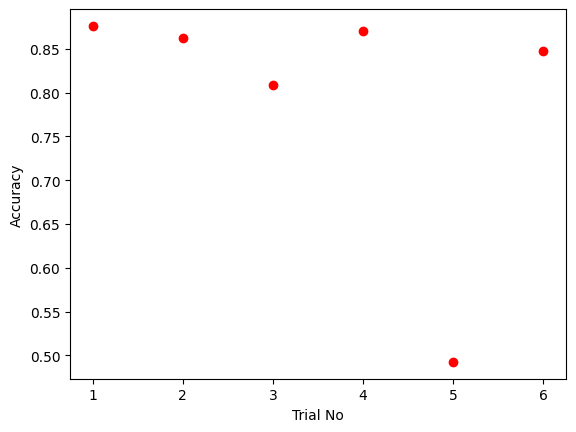

In [ ]:
accuracies = [acc1, acc2, acc3, acc4, acc5, acc6]
modelNo = [1, 2, 3, 4, 5, 6]
plt.plot(modelNo, accuracies, 'o', color='red')
plt.xlabel("Trial No")
plt.ylabel("Accuracy")

In [ ]:
print("Best Test Accuarcy: ", max(accuracies)*100, " which is model ", (accuracies.index(max(accuracies)) + 1))

Best Test Accuarcy:  87.62369751930237  which is model  1


# Take Input For LSTM

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.word_index = wordIndex

In [ ]:
def predict(input, tokenizer, model, label_encoder):
  preprocessedInput = ' '.join(preprocessing(input))
  input_seq = tokenizer.texts_to_sequences([preprocessedInput])
  data = pad_sequences(input_seq, maxlen=MAX_SEQUENCE_LENGTH) 
  predictions = model.predict(data)
  encoded_result = np.argmax(predictions[0])
  result = label_encoder.inverse_transform([encoded_result])
  print(result)

In [ ]:
inp = ''
while inp!='exit':
  inp = input("Give input for LSTM model: ")
  predict(inp, tokenizer, lstm1, label_encoder)

Give input for LSTM model: OpenAI continues to impress me with its incredible advancements in artificial intelligence. Their language models, like GPT-3, are revolutionizing the way we interact with technology. Exciting times ahead! #OpenAI #AI #Technology
1/1 [==============================] - 0s 374ms/step
['good']
Give input for LSTM model: Disappointed with OpenAI's latest release. The language model, GPT-3, is far from perfect and still generates inaccurate and misleading information. They need to improve their algorithms and provide better quality control. #OpenAI #GPT3 #Disappointed
1/1 [==============================] - 0s 23ms/step
['neutral']
Give input for LSTM model: Just tried out OpenAI's language model, GPT-3, and it's interesting. The technology has potential, but there are still some limitations and areas for improvement. Looking forward to seeing how OpenAI continues to develop their AI capabilities. #OpenAI #GPT3 #AI
1/1 [==============================] - 0s 34ms/ste

# CNN Model

In [ ]:
''' 
   CNN Model:
   1- Create the input layer and pass its output to the embedding layer
      embedding layer arguments -> - vocab size
                                   - embedding vector size
                                   - weights matrix
                                   - padded sequence length
                                   - freeze the weights
   2- Create 3 Conv1D layers with GlobalMaxPooling1D layer to take the output of the embedding layer and work in parallel
   3- Create a layer "merged" to concatenate the output from each GlobalMaxPooling1D layer (128 * numberOfConv)
   4- Create a dense layer with ReLU and an output layer with softmax for multi-class classification
'''
def defineCNNModel (numberOfConv = 1, l2Val = 0.0003, numOfFilters = 128, numOfDensUnits = 128, trainableBool = False):
  
  kernelSizes = [3, 4, 5, 6, 7]
  pools = []

  NUM_LABELS = 3

  sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedding_layer = Embedding((len(wordIndex) + 1), EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=trainableBool)(sequence_input)

  for i in range(0, numberOfConv):

    conv = Conv1D(numOfFilters, kernelSizes[i], activation='relu', kernel_regularizer=l2(l2Val))(embedding_layer)
    pool = GlobalMaxPooling1D()(conv)

    pools.append(pool)

  merged = tensorflow.keras.layers.concatenate(pools, axis=1)

  dense = Dense(numOfDensUnits, activation='relu')(merged)
  output = Dense(NUM_LABELS, activation='softmax')(dense)

  model = Model(inputs=sequence_input, outputs=output)

  return model

# Tuning CNN Model

In [ ]:
def tune_learningRate_CNN(numEpochs=25,trianableVal = False):

  lrs = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
  losses = []
  acc = []
  accuracyList = []
  numbers_of_conv = 1

  for lr in lrs:
    print('Learing Rate:', lr)
    print()
    model = defineCNNModel(numbers_of_conv, trainableBool = trianableVal)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    # callback -> to stop if 5 epoches and not improving 
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    
    history  = model.fit(x_train, yTrain, epochs=numEpochs, batch_size=128, validation_data=(x_val, y_val), callbacks=[callback], verbose=1)
    losses.append(history.history['val_loss'][-1])
    accuracyList.append(history.history['val_accuracy'][-1])

    print()
  
  minLossIndex = losses.index(min(losses))
  minLossLr = lrs[minLossIndex]

  plt.plot(lrs, losses, marker='o', markerfacecolor='blue', markersize=8)
  plt.xlabel('Learning Rate')
  plt.ylabel('Loss')
  plt.show()  

  plt.plot(lrs, accuracyList, marker='o', color='green', markersize=8)
  plt.xlabel('Learning Rate')
  plt.ylabel('Accuracy')
  plt.show()
  return minLossLr 

def tune_numberOfConv_Layers(lr,numEpochs=25, trianableVal = False):

  numbers_of_conv= [1, 2, 3, 4]
  losses = []
  accuracyList = []
  for numberOfconv in numbers_of_conv:
    print('Number of Conv1D:', numberOfconv)
    print()

    model = defineCNNModel(numberOfconv, trainableBool = trianableVal)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    # callback -> to stop if 5 epoches and not improving 
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history  = model.fit(x_train, yTrain, epochs=numEpochs, batch_size=128, validation_data=(x_val, y_val), callbacks=[callback], verbose=1)
    losses.append(history.history['val_loss'][-1])
    accuracyList.append(history.history['val_accuracy'][-1])

    print()


  minLossIndex = losses.index(min(losses))
  minLossConvLayer = numbers_of_conv[minLossIndex]

  plt.plot(numbers_of_conv, losses, marker='o', markerfacecolor='blue', markersize=8)
  plt.xlabel('Number of hidden layers')
  plt.ylabel('Loss')
  plt.show() 

  plt.plot(numbers_of_conv, accuracyList, marker='o', color='green', markersize=8)
  plt.xlabel('Number of hidden layers')
  plt.ylabel('Accuracy')
  plt.show()

  return minLossConvLayer

def tune_batchSize(numbers_of_conv, lr,numEpochs=25, trianableVal = False):

  batch_sizes = [16, 32, 64, 128, 256, 512]
  losses = []
  accuracyList = []
  for batch_size in batch_sizes:
    print('Batch Size:', batch_size)
    print()
    model = defineCNNModel(numbers_of_conv, trainableBool = trianableVal)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    # callback -> to stop if 5 epoches and not improving 
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    # verbose=1 -> displays messages when the callback takes an action
    history  = model.fit(x_train, yTrain, epochs=numEpochs, batch_size=batch_size, validation_data=(x_val, y_val) ,callbacks=[callback], verbose=1)
    losses.append(history.history['val_loss'][-1])
    accuracyList.append(history.history['val_accuracy'][-1])
    print()

  minLossIndex = losses.index(min(losses))
  minLossbatchSize = batch_sizes[minLossIndex]

  plt.plot(batch_sizes, losses, marker='o', markerfacecolor='blue', markersize=8)
  plt.xlabel('Batch Size')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(batch_sizes, accuracyList, marker='o', color='green', markersize=8)
  plt.xlabel('Batch Size')
  plt.ylabel('Accuracy')
  plt.show()
  
  return minLossbatchSize



def tuneL2(numberOfConv,lr,batchSize,numEpochs=25, trianableVal = False):

  l2_values = [0.1, 0.01, 0.007, 0.005, 0.003,  0.001, 0.0001, 0.0003, 0.0005, 0.0007]
  losses = []
  accuracyList = []
  for l2_val in l2_values:
    print('L2:', l2_val)
    print()

    model_4 = defineCNNModel(numberOfConv, l2_val, trainableBool = trianableVal)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    model_4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history  = model_4.fit(x_train, yTrain, epochs=numEpochs, batch_size=batchSize, validation_data=(x_val, y_val), callbacks=[callback], verbose=1)
    losses.append(history.history['val_loss'][-1])
    accuracyList.append(history.history['val_accuracy'][-1])
    print()


  minLossIndex = losses.index(min(losses))
  minLossL2 = l2_values[minLossIndex]

  plt.plot(l2_values, losses, marker='o', markerfacecolor='blue', markersize=8)
  plt.xlabel('L2 Values')
  plt.ylabel('Loss')
  plt.show() 

  plt.plot(l2_values, accuracyList, marker='o', color='green', markersize=8)
  plt.xlabel('L2 Values')
  plt.ylabel('Accuracy')
  plt.show()
  return minLossL2


In [ ]:
def tuneNumberOfFilters(convLayers = 3, learningRate = 0.005, batchSize = 256, l2Val = 0.0003, numEpochs = 25, trianableVal = False):
    numFiltersVals = [16, 32, 64, 128, 256, 512]
    losses = []
    accuracyList = []

    for filters in numFiltersVals:
        print('filters:', filters)
        print()

        model = defineCNNModel(convLayers, l2Val, filters, trainableBool = trianableVal)
        optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)

        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        history  = model.fit(x_train, yTrain, epochs=numEpochs, batch_size=batchSize, validation_data=(x_val, y_val), callbacks=[callback], verbose=1)
        losses.append(history.history['val_loss'][-1])

        accuracyList.append(history.history['val_accuracy'][-1])
        print()


    minLossIndex = losses.index(min(losses))
    minLossfilters = numFiltersVals[minLossIndex]

    plt.plot(numFiltersVals, losses, marker='o', markerfacecolor='blue', markersize=8)
    plt.xlabel('Number of Filters')
    plt.ylabel('Loss')
    plt.show() 

    plt.plot(numFiltersVals, accuracyList, marker='o', color='green', markersize=8)
    plt.xlabel('Number of Filters')
    plt.ylabel('Accuracy')
    plt.show()

    return minLossfilters

In [ ]:
def tuneNumberOfDenseUnits(numOfFilters, convLayers = 3, learningRate = 0.005, batchSize = 256, l2Val = 0.0003, numEpochs = 25, trianableVal = False):
    numberOfDenseUnits = [16, 32, 64, 128, 256, 512]
    losses = []
    accuracyList = []
    for numberOfDense in numberOfDenseUnits:
        print('Dense Units:', numberOfDense)
        print()

        model = defineCNNModel(convLayers, l2Val, numOfFilters, numberOfDense, trainableBool = trianableVal)
        optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)

        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        history  = model.fit(x_train, yTrain, epochs=numEpochs, batch_size=batchSize, validation_data=(x_val, y_val), callbacks=[callback], verbose=1)
        losses.append(history.history['val_loss'][-1])

        accuracyList.append(history.history['val_accuracy'][-1])
        print()


    minLossIndex = losses.index(min(losses))
    minLossDenseUnits = numberOfDenseUnits[minLossIndex]

    plt.plot(numberOfDenseUnits, losses, marker='o', markerfacecolor='blue', markersize=8)
    plt.xlabel('Number of Dense Units')
    plt.ylabel('Loss')
    plt.show() 

    plt.plot(numberOfDenseUnits, accuracyList, marker='o', color='green', markersize=8)
    plt.xlabel('Number of Dense Units')
    plt.ylabel('Accuracy')
    plt.show()

    return minLossDenseUnits

In [ ]:
learningRate = tune_learningRate_CNN()

In [ ]:
learningRate

**The best learning rate after tuning was [ 0.005 ]**



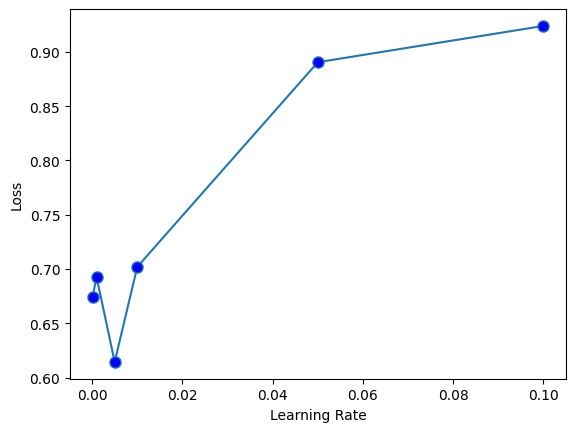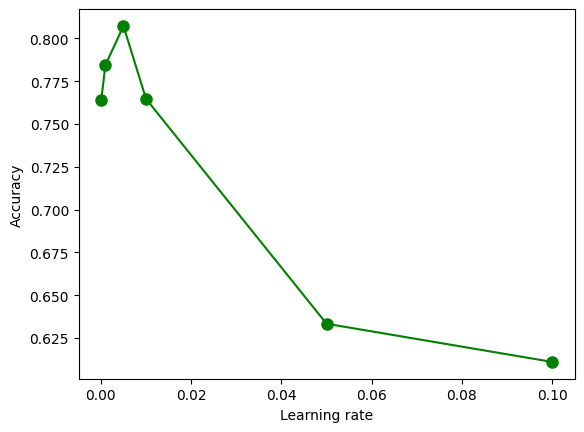





In [ ]:
learningRate = 0.005
convLayers = tune_numberOfConv_Layers(learningRate)

In [ ]:
convLayers

**The best number of Conv1D layers after tuning was [ 3 ]**


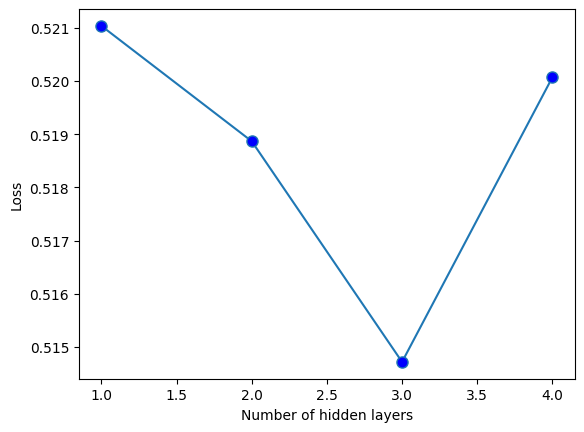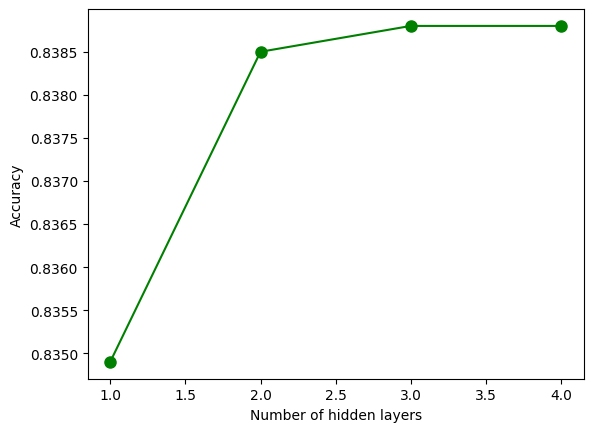

In [ ]:
convLayers = 3
learningRate = 0.005
batchSize = tune_batchSize(convLayers, learningRate)

In [ ]:
batchSize

**The best batch size after tuning was [ 256 ]**


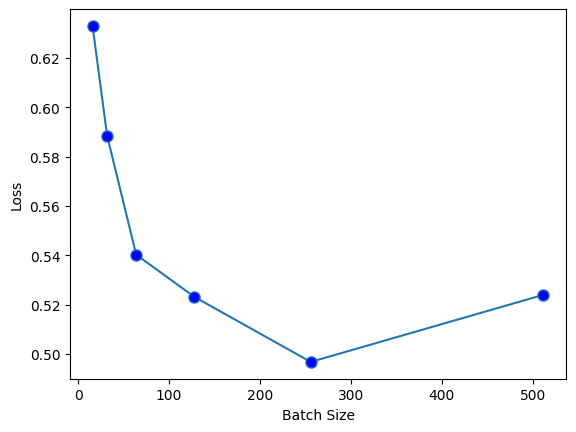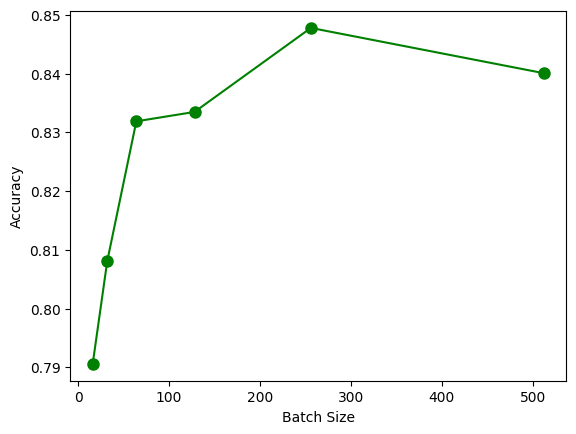

In [ ]:
convLayers = 3
learningRate = 0.005
batchSize = 256

In [ ]:
l2Val = tuneL2(convLayers, learningRate, batchSize)

In [ ]:
l2Val

**The best L2 value was [ 0.0003 ]**


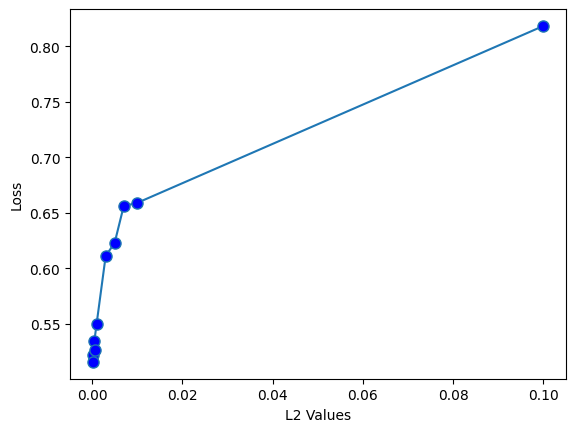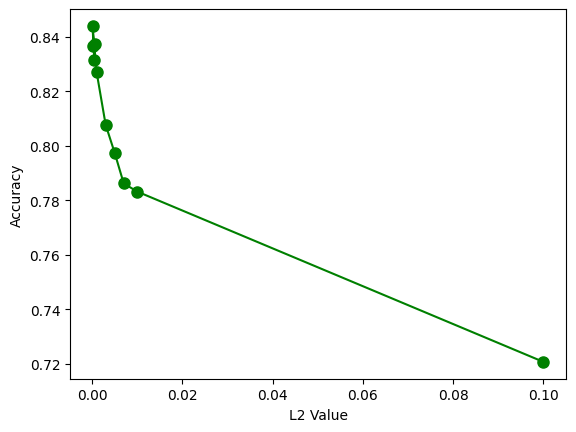

In [ ]:
numberOfFilters = tuneNumberOfFilters()

In [ ]:
numberOfFilters = 256

**The best number of filters after tuning was [ 256 ]**


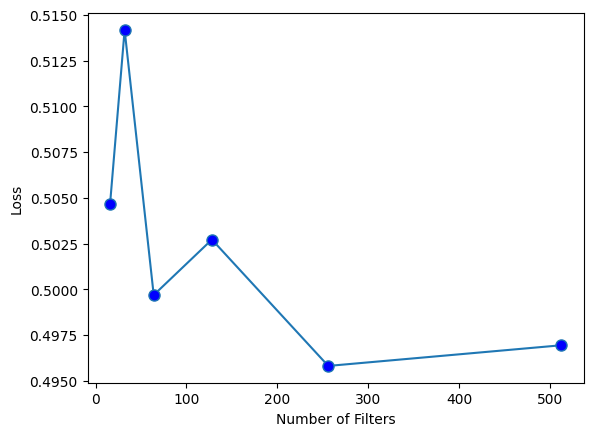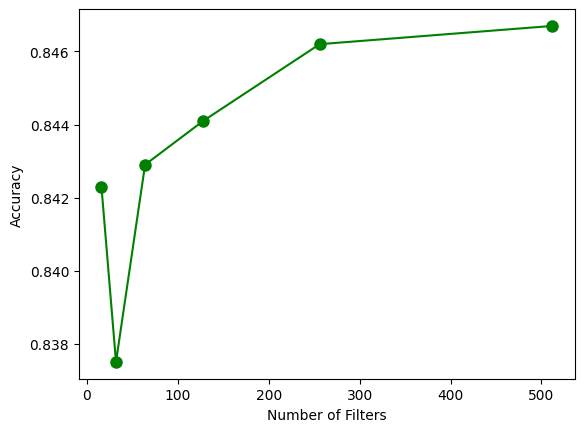

In [ ]:
numberOfDenseUnits = tuneNumberOfDenseUnits(numberOfFilters)

In [ ]:
numberOfDenseUnits = 512

**The best number of dense units after tuning was [ 512 ]**


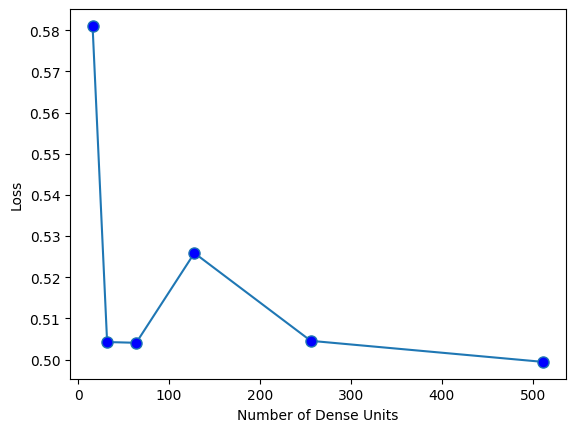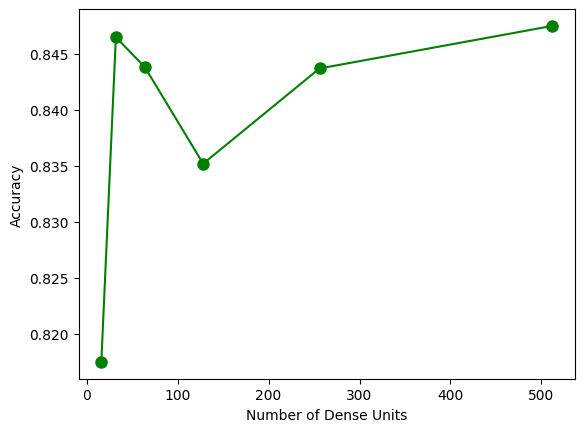

# Final Hyperparameters values after tuning (Trainable = False)

In [ ]:
convLayers = 3
learningRate = 0.005
batchSize = 256
l2Val = 0.0003
numberOfFilters = 256
numberOfDenseUnits = 512
numEpochs = 25

# CNN model with (Trainable = False) (Model 0)

The weights of the embedding layer are not trainable(using the pre-trained only)

In [ ]:
cnnModelNotTrainableWeights = defineCNNModel  (convLayers, l2Val, numberOfFilters, numberOfDenseUnits)
optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)
cnnModelNotTrainableWeights.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnnModelNotTrainableWeights.fit(x_train, yTrain, epochs=5, batch_size=batchSize, validation_data=(x_val, y_val))

Epoch 1/5
549/549 [==============================] - 71s 104ms/step - loss: 0.8650 - accuracy: 0.7351 - val_loss: 0.6846 - val_accuracy: 0.7899
Epoch 2/5
549/549 [==============================] - 63s 115ms/step - loss: 0.6682 - accuracy: 0.7973 - val_loss: 0.6727 - val_accuracy: 0.7867
Epoch 3/5
549/549 [==============================] - 59s 107ms/step - loss: 0.6174 - accuracy: 0.8127 - val_loss: 0.6122 - val_accuracy: 0.8074
Epoch 4/5
549/549 [==============================] - 64s 116ms/step - loss: 0.5785 - accuracy: 0.8220 - val_loss: 0.5731 - val_accuracy: 0.8164
Epoch 5/5
549/549 [==============================] - 63s 115ms/step - loss: 0.5498 - accuracy: 0.8276 - val_loss: 0.5521 - val_accuracy: 0.8251


In [ ]:
# evaluate the model
cnnModelNotTrainableWeightsLoss, cnnModelNotTrainableWeightsAccuracy = cnnModelNotTrainableWeights.evaluate(x_test, yTest)
print(cnnModelNotTrainableWeightsLoss, cnnModelNotTrainableWeightsAccuracy)

1371/1371 [==============================] - 11s 7ms/step - loss: 0.5483 - accuracy: 0.8269
0.5482653379440308 0.8269414901733398


# Tune Hyperparameters (Trainable = True)
Double-check if there are more suitable hyperparameters for this model, after making the weights of the embedding layer trainable

In [ ]:
learningRateTrainable = tune_learningRate_CNN(numEpochs=5,trianableVal = True)

In [ ]:
learningRateTrainable

0.01

**The best learning rate after tuning was [0.01]**



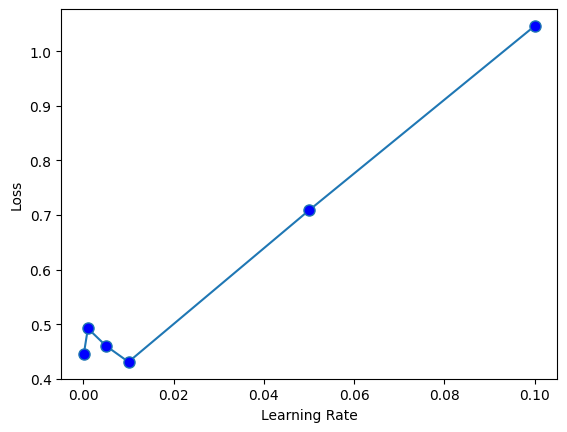 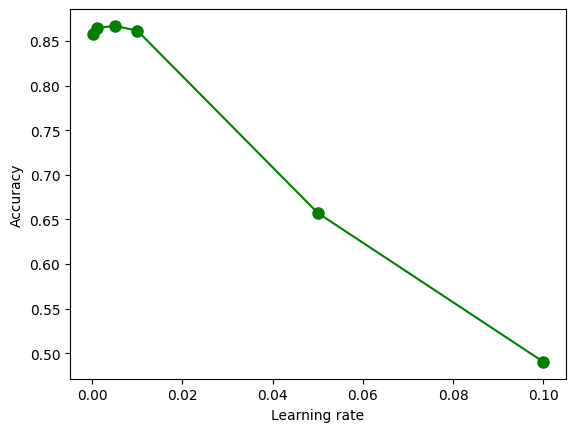

In [ ]:
convLayersTrainable = tune_numberOfConv_Layers(learningRateTrainable,numEpochs=5, trianableVal = True)

In [ ]:
convLayersTrainable

1

**The best number of Conv1D layers after tuning was [ 1 ]**


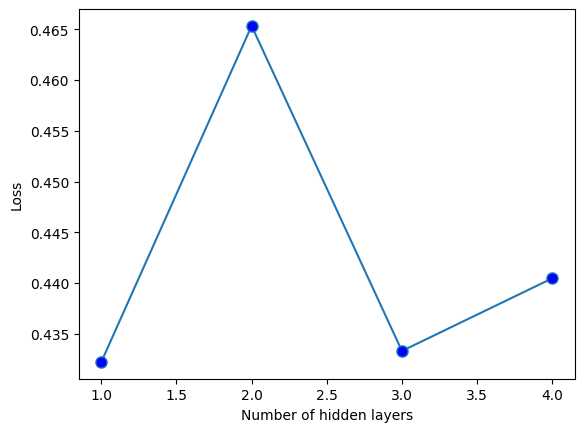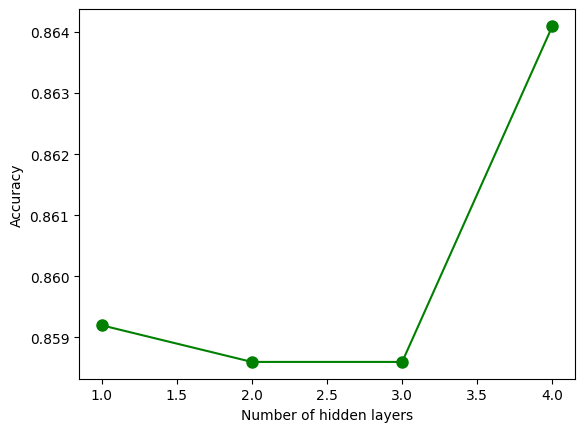

In [ ]:
learningRateTrainable = 0.01
convLayersTrainable = 1

In [ ]:
batchSizeTrianable = tune_batchSize(convLayersTrainable, learningRateTrainable,numEpochs=5, trianableVal = True)

In [ ]:
batchSizeTrianable

64

**The best batch size after tuning was [ 64 ]**


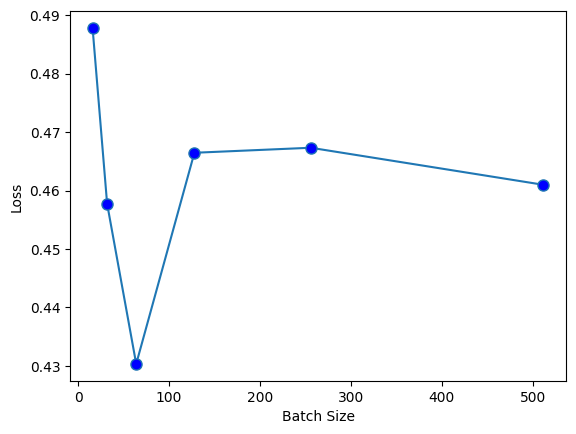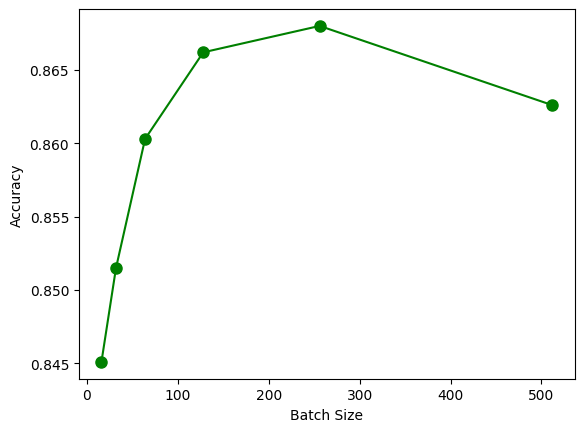

In [ ]:
batchSizeTrianable = 64

In [ ]:
l2Trainable = tuneL2(convLayersTrainable, learningRateTrainable, batchSizeTrianable, numEpochs=5, trianableVal = True)

In [ ]:
l2Trainable

0.0003

**The best L2 value after tuning was [ 0.0003 ]**


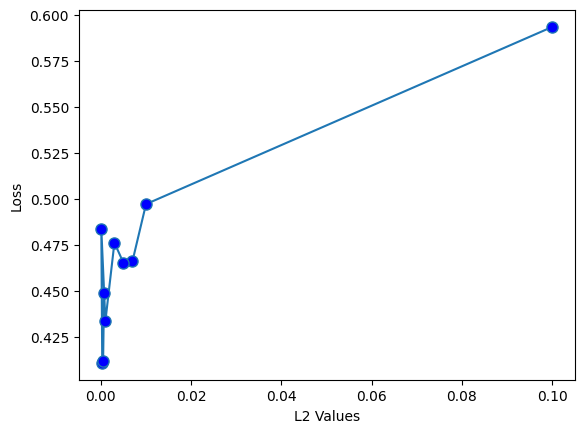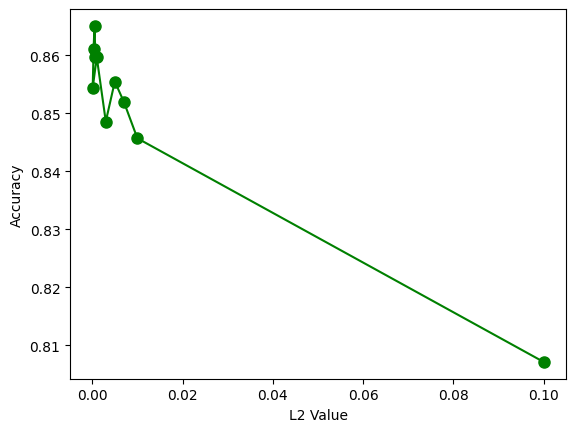

In [ ]:
l2Trainable = 0.0003

In [ ]:
numFiltersTrainable = tuneNumberOfFilters(convLayersTrainable, learningRateTrainable, batchSizeTrianable, l2Trainable, numEpochs = 5, trianableVal = True)

In [ ]:
numFiltersTrainable

256

**The best number of filters after tuning was [ 256 ]**


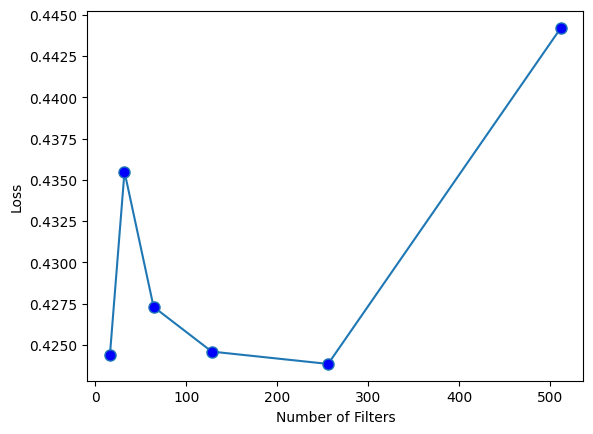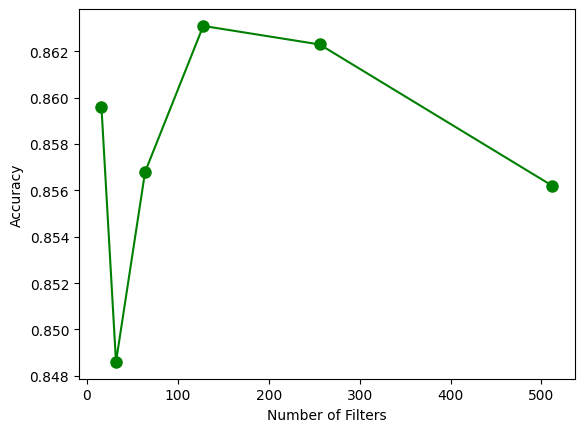

In [ ]:
numFiltersTrainable = 256

In [ ]:
denseUnitsTrainable = tuneNumberOfDenseUnits(numFiltersTrainable, convLayersTrainable, learningRateTrainable, batchSizeTrianable, l2Trainable, numEpochs = 5, trianableVal = True)

In [ ]:
denseUnitsTrainable

256

**The best number of dense units after tuning was [ 256 ]**


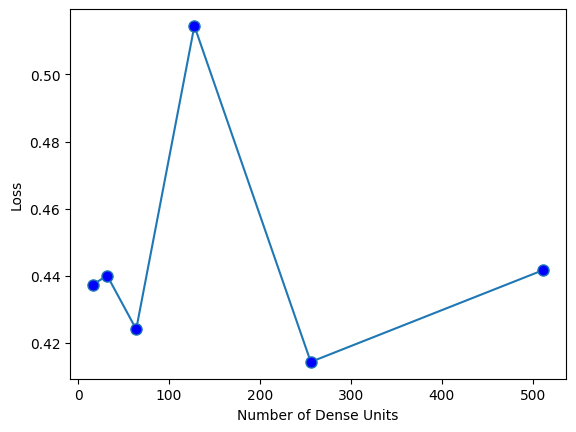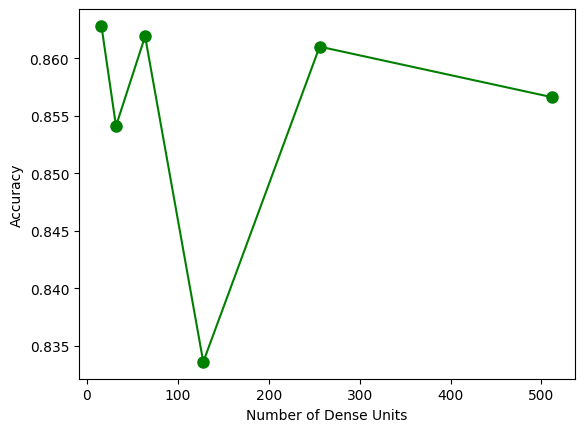

# Hyperparameters after tuning 
(the model with trainable weights of the embedding layer)


In [ ]:
learningRateTrainable = 0.01
convLayersTrainable = 1
batchSizeTrianable = 64
l2Trainable = 0.0003
numFiltersTrainable = 256
denseUnitsTrainable = 256
numEpochs = 5

# CNN model after second tuning with (Trainable = True) (Model 1)

* *learningRateTrainable = 0.01*
* *convLayersTrainable = 1*
* *batchSizeTrianable = 64*
* *l2Trainable = 0.0003*
* *numFiltersTrainable = 256*
* *denseUnitsTrainable = 256*
* *numEpochs = 5*

In [ ]:
cnnModel1 = defineCNNModel (convLayersTrainable, l2Trainable, numFiltersTrainable, denseUnitsTrainable,  trainableBool = True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learningRateTrainable)
cnnModel1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnnModel1.fit(x_train, yTrain, epochs=numEpochs, batch_size=batchSizeTrianable, validation_data=(x_val, y_val))

Epoch 1/5
2193/2193 [==============================] - 99s 44ms/step - loss: 0.5682 - accuracy: 0.8165 - val_loss: 0.4462 - val_accuracy: 0.8498
Epoch 2/5
2193/2193 [==============================] - 64s 29ms/step - loss: 0.4012 - accuracy: 0.8659 - val_loss: 0.4093 - val_accuracy: 0.8603
Epoch 3/5
2193/2193 [==============================] - 56s 25ms/step - loss: 0.3625 - accuracy: 0.8801 - val_loss: 0.4052 - val_accuracy: 0.8634
Epoch 4/5
2193/2193 [==============================] - 54s 25ms/step - loss: 0.3339 - accuracy: 0.8922 - val_loss: 0.4201 - val_accuracy: 0.8647
Epoch 5/5
2193/2193 [==============================] - 54s 24ms/step - loss: 0.3121 - accuracy: 0.9017 - val_loss: 0.4288 - val_accuracy: 0.8646


In [ ]:
cnnModelLoss1, cnnModelAccuracy1 = cnnModel1.evaluate(x_test, yTest)
print(cnnModelLoss1, cnnModelAccuracy1)

1371/1371 [==============================] - 6s 4ms/step - loss: 0.4380 - accuracy: 0.8621
0.43796807527542114 0.8620775938034058


# CNN model with old hyperparameters (Model 2)
* *convLayers = 3*
* *learningRate = 0.005*
* *batchSize = 256*
* *l2Val = 0.0003*
* *numberOfFilters = 256*
* *numberOfDenseUnits = 512*
* *numEpochs = 5*





In [ ]:
cnnModel2 = defineCNNModel (convLayers, l2Val, numberOfFilters, numberOfDenseUnits,  trainableBool = True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)
cnnModel2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnnModel2.fit(x_train, yTrain, epochs=numEpochs, batch_size=batchSize, validation_data=(x_val, y_val))

Epoch 1/5
549/549 [==============================] - 131s 233ms/step - loss: 0.6048 - accuracy: 0.8244 - val_loss: 0.4271 - val_accuracy: 0.8769
Epoch 2/5
549/549 [==============================] - 99s 180ms/step - loss: 0.3814 - accuracy: 0.8886 - val_loss: 0.3974 - val_accuracy: 0.8747
Epoch 3/5
549/549 [==============================] - 95s 173ms/step - loss: 0.3153 - accuracy: 0.9105 - val_loss: 0.4246 - val_accuracy: 0.8702
Epoch 4/5
549/549 [==============================] - 92s 167ms/step - loss: 0.2651 - accuracy: 0.9268 - val_loss: 0.4431 - val_accuracy: 0.8665
Epoch 5/5
549/549 [==============================] - 95s 173ms/step - loss: 0.2232 - accuracy: 0.9403 - val_loss: 0.4694 - val_accuracy: 0.8661


In [ ]:
cnnModelLoss2, cnnModelAccuracy2 = cnnModel2.evaluate(x_test, yTest)
print(cnnModelLoss2, cnnModelAccuracy2)

1371/1371 [==============================] - 11s 8ms/step - loss: 0.4761 - accuracy: 0.8644
0.4761405885219574 0.8643577098846436


# More Trials [ 4 ]

## Model 3

In [ ]:
cnnModel3 = defineCNNModel (numberOfConv = 2, l2Val = 0.0003, numOfFilters = 64, numOfDensUnits = 128,  trainableBool = False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
cnnModel3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnnModel3.fit(x_train, yTrain, epochs=numEpochs, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/5
1097/1097 [==============================] - 20s 16ms/step - loss: 0.7191 - accuracy: 0.7487 - val_loss: 0.6623 - val_accuracy: 0.7831
Epoch 2/5
1097/1097 [==============================] - 17s 15ms/step - loss: 0.6301 - accuracy: 0.7965 - val_loss: 0.6010 - val_accuracy: 0.8089
Epoch 3/5
1097/1097 [==============================] - 17s 15ms/step - loss: 0.5968 - accuracy: 0.8089 - val_loss: 0.5820 - val_accuracy: 0.8158
Epoch 4/5
1097/1097 [==============================] - 16s 14ms/step - loss: 0.5725 - accuracy: 0.8175 - val_loss: 0.5755 - val_accuracy: 0.8166
Epoch 5/5
1097/1097 [==============================] - 17s 15ms/step - loss: 0.5579 - accuracy: 0.8236 - val_loss: 0.5562 - val_accuracy: 0.8260


In [ ]:
cnnModelLoss3, cnnModelAccuracy3 = cnnModel3.evaluate(x_test, yTest)
print(cnnModelLoss3, cnnModelAccuracy3)

1371/1371 [==============================] - 7s 5ms/step - loss: 0.5566 - accuracy: 0.8223
0.5565915703773499 0.8223357200622559


## Model 4

In [ ]:
cnnModel4 = defineCNNModel (numberOfConv = 4, l2Val = 0.0003, numOfFilters = 64, numOfDensUnits = 128,  trainableBool = False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
cnnModel4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnnModel4.fit(x_train, yTrain, epochs=numEpochs, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/5
1097/1097 [==============================] - 35s 29ms/step - loss: 0.7784 - accuracy: 0.7457 - val_loss: 0.6889 - val_accuracy: 0.7808
Epoch 2/5
1097/1097 [==============================] - 32s 29ms/step - loss: 0.6550 - accuracy: 0.7945 - val_loss: 0.6181 - val_accuracy: 0.8020
Epoch 3/5
1097/1097 [==============================] - 34s 31ms/step - loss: 0.6072 - accuracy: 0.8077 - val_loss: 0.5828 - val_accuracy: 0.8174
Epoch 4/5
1097/1097 [==============================] - 34s 31ms/step - loss: 0.5821 - accuracy: 0.8162 - val_loss: 0.5773 - val_accuracy: 0.8157
Epoch 5/5
1097/1097 [==============================] - 32s 29ms/step - loss: 0.5672 - accuracy: 0.8214 - val_loss: 0.5654 - val_accuracy: 0.8239


In [ ]:
cnnModelLoss4, cnnModelAccuracy4 = cnnModel3.evaluate(x_test, yTest)
print(cnnModelLoss4, cnnModelAccuracy4)

1371/1371 [==============================] - 6s 5ms/step - loss: 0.5566 - accuracy: 0.8223
0.5565915703773499 0.8223357200622559


## Model 5


In [ ]:
cnnModel5 = defineCNNModel (numberOfConv = 2, l2Val = 0.007, numOfFilters = 64, numOfDensUnits = 128,  trainableBool = True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
cnnModel5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnnModel5.fit(x_train, yTrain, epochs=numEpochs, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/5
1097/1097 [==============================] - 73s 65ms/step - loss: 0.6638 - accuracy: 0.8083 - val_loss: 0.5356 - val_accuracy: 0.8364
Epoch 2/5
1097/1097 [==============================] - 39s 35ms/step - loss: 0.4895 - accuracy: 0.8519 - val_loss: 0.4992 - val_accuracy: 0.8443
Epoch 3/5
1097/1097 [==============================] - 35s 32ms/step - loss: 0.4395 - accuracy: 0.8655 - val_loss: 0.4683 - val_accuracy: 0.8529
Epoch 4/5
1097/1097 [==============================] - 35s 32ms/step - loss: 0.4111 - accuracy: 0.8758 - val_loss: 0.4966 - val_accuracy: 0.8408
Epoch 5/5
1097/1097 [==============================] - 35s 32ms/step - loss: 0.3886 - accuracy: 0.8845 - val_loss: 0.4859 - val_accuracy: 0.8451


In [ ]:
cnnModelLoss5, cnnModelAccuracy5 = cnnModel5.evaluate(x_test, yTest)
print(cnnModelLoss5, cnnModelAccuracy5)

1371/1371 [==============================] - 7s 5ms/step - loss: 0.4928 - accuracy: 0.8464
0.492756724357605 0.8463678359985352


## Model 6

In [ ]:
cnnModel6 = defineCNNModel (numberOfConv = 4, l2Val = 0.003, numOfFilters = 64, numOfDensUnits = 128,  trainableBool = True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
cnnModel6.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnnModel6.fit(x_train, yTrain, epochs=numEpochs, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/5
1097/1097 [==============================] - 94s 82ms/step - loss: 1.3910 - accuracy: 0.7560 - val_loss: 0.7375 - val_accuracy: 0.7998
Epoch 2/5
1097/1097 [==============================] - 57s 52ms/step - loss: 0.7561 - accuracy: 0.8029 - val_loss: 0.6746 - val_accuracy: 0.8216
Epoch 3/5
1097/1097 [==============================] - 58s 53ms/step - loss: 0.6942 - accuracy: 0.8202 - val_loss: 0.6178 - val_accuracy: 0.8164
Epoch 4/5
1097/1097 [==============================] - 55s 50ms/step - loss: 0.6156 - accuracy: 0.8351 - val_loss: 0.7075 - val_accuracy: 0.8284
Epoch 5/5
1097/1097 [==============================] - 57s 52ms/step - loss: 1.0366 - accuracy: 0.5661 - val_loss: 1.0887 - val_accuracy: 0.4903


In [ ]:
cnnModelLoss6, cnnModelAccuracy6 = cnnModel6.evaluate(x_test, yTest)
print(cnnModelLoss6, cnnModelAccuracy6)

1371/1371 [==============================] - 8s 6ms/step - loss: 1.0871 - accuracy: 0.4925
1.0870952606201172 0.492498517036438


# Plot Accuracy of the trials


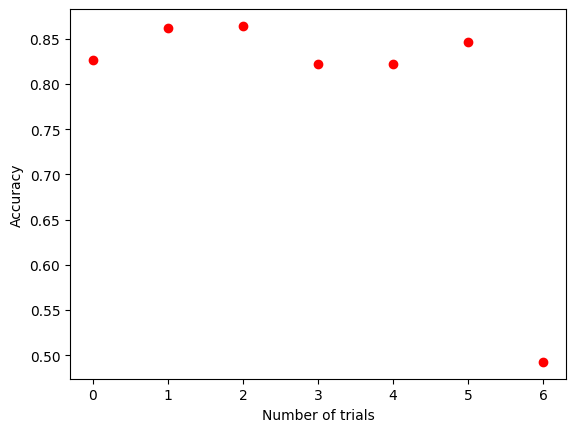

In [ ]:
accuracyTrails = [cnnModelNotTrainableWeightsAccuracy, cnnModelAccuracy1, cnnModelAccuracy2, cnnModelAccuracy3, cnnModelAccuracy4, cnnModelAccuracy5, cnnModelAccuracy6]
numberOfTrials = [0, 1, 2, 3, 4, 5, 6]

plt.scatter(numberOfTrials, accuracyTrails, marker='o', color='red')
plt.xlabel('Number of trials')
plt.ylabel('Accuracy')
plt.show() 

# Take Input For CNN

**The final CNN model chosen was [ cnnModel1 ] as it has a smaller loss than the models with the same accuracy.**




In [ ]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.word_index = wordIndex

In [ ]:
def predict(input, tokenizer, model, label_encoder):
  preprocessedInput = ' '.join(preprocessing(input))
  input_seq = tokenizer.texts_to_sequences([preprocessedInput])
  data = pad_sequences(input_seq, maxlen=MAX_SEQUENCE_LENGTH) 
  predictions = model.predict(data)
  encoded_result = np.argmax(predictions[0])
  result = label_encoder.inverse_transform([encoded_result])
  print(result)

In [ ]:
inp = input()
while inp!='exit':
  predict(inp, tokenizer, cnnModel1, label_encoder)
  inp = input()

ChatGPT is amazing! It always knows the answers to my questions. #AI #chatbot #amazing
1/1 [==============================] - 0s 22ms/step
['good']
ChatGPT is helpful for basic questions, but it's not always reliable. #AI #chatbot #helpfulbutnotperfect
1/1 [==============================] - 0s 22ms/step
['neutral']
ChatGPT is terrible. It never understands what I'm asking and its responses are always wrong. #AI #chatbot #terrible
1/1 [==============================] - 0s 30ms/step
['bad']
I love using ChatGPT for research! It's like having a personal assistant that knows everything. #AI #chatbot #research
1/1 [==============================] - 0s 31ms/step
['good']
ChatGPT can be useful for quick answers, but it's not a substitute for human expertise. #AI #chatbot #usefulbutnotperfect
1/1 [==============================] - 0s 20ms/step
['neutral']
ChatGPT is a waste of time. Its responses are always irrelevant and it never understands what I'm asking. #AI #chatbot #wasteoftime
1/1 [===